In [1]:
import sklearn
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # plot
from sklearn.linear_model import LinearRegression # model that we need
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

sklearn.__version__

'1.5.2'

The following cell is not necessarily needed but can help avoid some slowdowns when running this notebooks on some machines.

In [2]:
import threadpoolctl
import joblib


n_physical_cpus = joblib.cpu_count(only_physical_cores=True)
threadpoolctl.threadpool_limits(limits=n_physical_cpus);
threadpoolctl.threadpool_info()

[{'user_api': 'openmp',
  'internal_api': 'openmp',
  'num_threads': 4,
  'prefix': 'vcomp',
  'filepath': 'C:\\Users\\mehrd\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\sklearn\\.libs\\vcomp140.dll',
  'version': None},
 {'user_api': 'blas',
  'internal_api': 'openblas',
  'num_threads': 4,
  'prefix': 'libopenblas',
  'filepath': 'C:\\Users\\mehrd\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\numpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll',
  'version': '0.3.23.dev',
  'threading_layer': 'pthreads',
  'architecture': 'Haswell'},
 {'user_api': 'blas',
  'internal_api': 'openblas',
  'num_threads': 4,
  'prefix': 'libopenblas',
  'filepath': 'C:\\Users\\mehrd\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\scipy.libs\\libopenblas_v0.3.26-382-gb1e8ba50--72a863714eca5a50b38260dedc0c2f3a.dll',
  'version': '0.3.26.dev',
  'threading_layer': 'pthreads',
  'architecture': 'Haswell'}]

<h1>Data exploration on the Volve production well number 2 dataset</h1>
We start by loading the data from the excel.

In [3]:
# read the orginal data from the csv file
df1 = pd.read_csv("well2.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2013-07-24', periods=1152, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')

df = df[[
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"]]
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df.dropna(inplace=True)
df.head()

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
date,,,,,,
2013-07-24,1.926270,0.35220,26.123040,3.256548,9505.611429,0
2013-07-25,163.594260,60.31574,61.473080,8.549131,108940.110000,1
2013-07-28,0.000000,0.00000,0.000000,2.464222,257479.142857,4
2013-07-29,0.000000,0.00000,0.000000,2.536987,112755.000000,5
2013-07-31,273.946931,105.55137,179.382345,2.540804,137705.269214,7


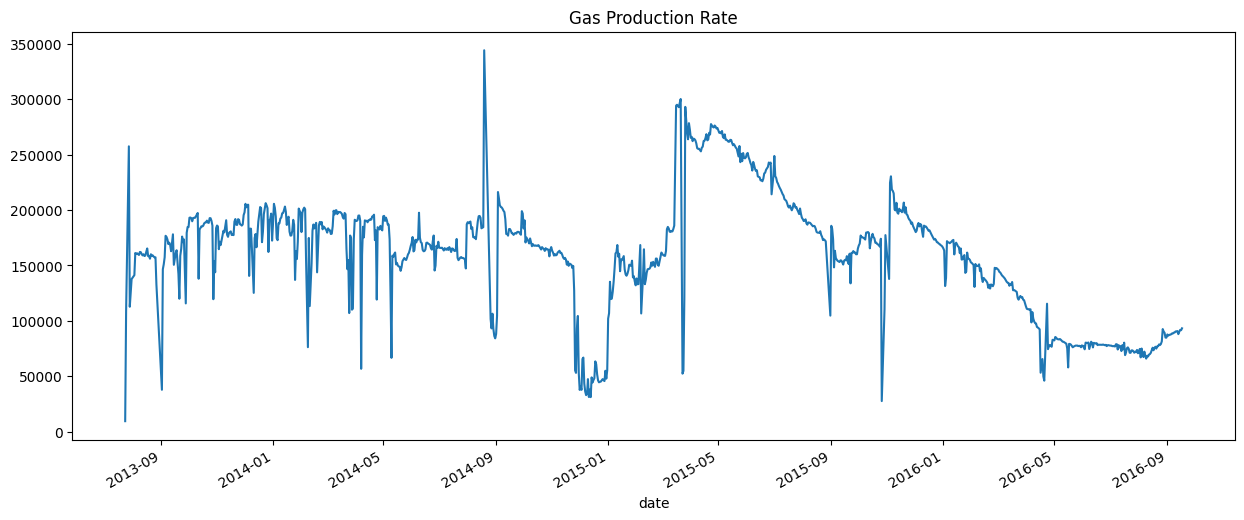

In [4]:
df["QG"].plot(figsize=(15, 6))
_ = plt.title("Gas Production Rate")

In [5]:
df["QG"].describe()

count      1119.000000
mean     159927.183650
std       53677.532907
min        9505.611429
25%      135086.395000
50%      166589.510000
75%      188823.910000
max      344150.263368
Name: QG, dtype: float64

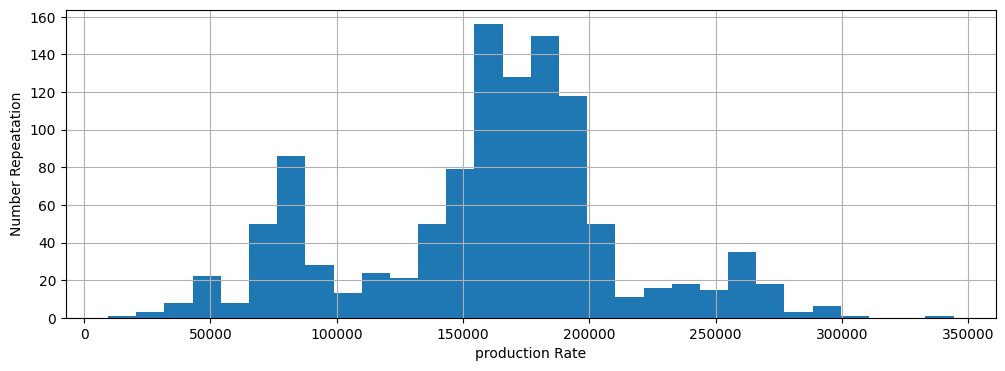

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
df["QG"].hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="production Rate",
    ylabel="Number Repeatation",
)

<h1>Time-series Forecasting via Tabularization</h1>
Let's consider the problem of predicting the demand at the next hour given past demands.

Since the demand is a continuous variable, one could intuitively use any regression model.

However we don't have the usual (X_train, y_train) dataset.

Instead we just have y_train demand data sequentially organized by time.


In [7]:
search_terms = ["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "Time"]
X0=make_lags(df[search_terms], lags=4)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]
X0

NameError: name 'make_lags' is not defined

In [8]:
search_terms = ["bhp", "bht", "dp_tubing", "AVG_CHOKE_SIZE_P", "Time", "QG"]

def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_roling_lag(df, name="QG"):
    return pd.concat(
        [
            df.shift(1).rolling(7).mean().rename(f"{name}_lagged_mean_7D"),
            df.shift(1).rolling(7).max().rename(f"{name}_lagged_max_7D"),
            df.shift(1).rolling(7).min().rename(f"{name}_lagged_min_7D"),
            df.shift(1).rolling(15).mean().rename(f"{name}_lagged_mean_15D"),
            df.shift(1).rolling(15).max().rename(f"{name}_lagged_max_15D"),
            df.shift(1).rolling(15).min().rename(f"{name}_lagged_min_15D"),
            df.shift(1).rolling(30).mean().rename(f"{name}_lagged_mean_30D"),
            df.shift(1).rolling(30).max().rename(f"{name}_lagged_max_30D"),
            df.shift(1).rolling(30).min().rename(f"{name}_lagged_min_30D"),
        ],
        axis="columns"
    )

lags=make_lags(df[search_terms], lags=7)
lags.columns = [' '.join(col).strip() for col in lags.columns.values]
lagged_df = pd.concat(
    [
        df,
        lags,
        make_roling_lag(df["QG"], name="QG"),
        make_roling_lag(df["bhp"], name="bhp"),
        make_roling_lag(df["bht"], name="bht"),
        make_roling_lag(df["dp_tubing"], name="dp_tubing"),
        make_roling_lag(df["AVG_CHOKE_SIZE_P"], name="AVG_CHOKE_SIZE_P")
    ],
    axis="columns",
)
X = lagged_df.copy().fillna(0.0)
X

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time,y_lag_1 bhp,y_lag_1 bht,y_lag_1 dp_tubing,y_lag_1 AVG_CHOKE_SIZE_P,...,dp_tubing_lagged_min_30D,AVG_CHOKE_SIZE_P_lagged_mean_7D,AVG_CHOKE_SIZE_P_lagged_max_7D,AVG_CHOKE_SIZE_P_lagged_min_7D,AVG_CHOKE_SIZE_P_lagged_mean_15D,AVG_CHOKE_SIZE_P_lagged_max_15D,AVG_CHOKE_SIZE_P_lagged_min_15D,AVG_CHOKE_SIZE_P_lagged_mean_30D,AVG_CHOKE_SIZE_P_lagged_max_30D,AVG_CHOKE_SIZE_P_lagged_min_30D
date,,,,,,,,,,,,,,,,,,,,,
2013-07-24,1.926270,0.352200,26.123040,3.256548,9505.611429,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2013-07-25,163.594260,60.315740,61.473080,8.549131,108940.110000,1,1.926270,0.352200,26.123040,3.256548,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2013-07-28,0.000000,0.000000,0.000000,2.464222,257479.142857,4,163.594260,60.315740,61.473080,8.549131,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2013-07-29,0.000000,0.000000,0.000000,2.536987,112755.000000,5,0.000000,0.000000,0.000000,2.464222,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2013-07-31,273.946931,105.551370,179.382345,2.540804,137705.269214,7,0.000000,0.000000,0.000000,2.536987,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-13,253.399422,105.266981,226.400814,100.000000,88042.160000,1147,253.658108,105.259036,226.680342,100.000000,...,223.897904,100.0,100.0,100.0,99.722222,100.0,97.916667,99.368745,100.0,97.916667
2016-09-14,253.209915,105.271539,226.255384,100.000000,90188.970000,1148,253.399422,105.266981,226.400814,100.000000,...,223.897904,100.0,100.0,100.0,99.722222,100.0,97.916667,99.420539,100.0,97.916667
2016-09-15,252.938710,105.274111,226.036656,100.000000,91890.070000,1149,253.209915,105.271539,226.255384,100.000000,...,223.897904,100.0,100.0,100.0,99.722222,100.0,97.916667,99.472771,100.0,97.916667


In [9]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(df["QG"], steps=10).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)
y

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10
date,,,,,,,,,,
2013-07-24,9505.611429,108940.110000,257479.142857,112755.000000,137705.269214,141268.448264,161227.00,160270.49,160951.30,160232.470000
2013-07-25,108940.110000,257479.142857,112755.000000,137705.269214,141268.448264,161227.000000,160270.49,160951.30,160232.47,159483.760000
2013-07-28,257479.142857,112755.000000,137705.269214,141268.448264,161227.000000,160270.490000,160951.30,160232.47,159483.76,162196.780000
2013-07-29,112755.000000,137705.269214,141268.448264,161227.000000,160270.490000,160951.300000,160232.47,159483.76,162196.78,161999.010000
2013-07-31,137705.269214,141268.448264,161227.000000,160270.490000,160951.300000,160232.470000,159483.76,162196.78,161999.01,160095.110000
...,...,...,...,...,...,...,...,...,...,...
2016-09-04,87504.870000,87798.790000,88650.380000,88563.480000,89379.120000,89482.000000,90470.31,90540.97,90810.01,88042.160000
2016-09-05,87798.790000,88650.380000,88563.480000,89379.120000,89482.000000,90470.310000,90540.97,90810.01,88042.16,90188.970000
2016-09-06,88650.380000,88563.480000,89379.120000,89482.000000,90470.310000,90540.970000,90810.01,88042.16,90188.97,91890.070000


In [10]:
# Normalize features 
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X.values)
series_X = pd.DataFrame(scaled_X, columns=X.columns)
scaled_y = scaler_y.fit_transform(y.values)
series_y = pd.DataFrame(scaled_y, columns=y.columns)
print(series_y.head())
print(series_y.shape)

   y_step_1  y_step_2  y_step_3  y_step_4  y_step_5  y_step_6  y_step_7  \
0  0.000000  0.256852  0.726162  0.268906  0.347736  0.358994  0.422053   
1  0.297135  0.726162  0.268906  0.347736  0.358994  0.422053  0.419031   
2  0.741006  0.268906  0.347736  0.358994  0.422053  0.419031  0.421182   
3  0.308534  0.347736  0.358994  0.422053  0.419031  0.421182  0.418911   
4  0.383092  0.358994  0.422053  0.419031  0.421182  0.418911  0.416545   

   y_step_8  y_step_9  y_step_10  
0  0.419031  0.421182   0.418911  
1  0.421182  0.418911   0.416545  
2  0.418911  0.416545   0.425117  
3  0.416545  0.425117   0.424492  
4  0.425117  0.424492   0.418477  
(1110, 10)


In [11]:
# Split data into training (70%) and test (30%)
nrow = round(0.7*X.shape[0])
X_train = series_X.iloc[:nrow, :]
y_train = series_y[:nrow]
X_test = series_X.iloc[nrow:,:]
y_test = series_y[nrow:]

In [12]:
X_train = X_train.values.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.values.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)
print(X_test.shape)

(777, 93, 1)
(333, 93, 1)


In [14]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (93,1), units= 93, return_sequences = True))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(16))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 93, 93)              │          35,340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 93, 256)             │         358,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 93, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 93, 64)              │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 93, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481,117 (1.84 MB)

 Trainable params: 481,117 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_loss',          # Metric to monitor (you can change it)
    save_best_only=True,         # Only save the best model (based on the monitored metric)
    mode='min',                  # 'min' because we want to minimize validation loss
    verbose=1                    # Verbosity mode, to see saving details in console
)
t1 = datetime.datetime.now()
history = model.fit(X_train, y_train["y_step_1"], epochs=250, batch_size=25, validation_data=(X_test,y_test["y_step_1"]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=25), checkpoint], verbose=1, shuffle=False)
t2 = datetime.datetime.now()
print("Compilation Time : ", t2-t1)

Epoch 1/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0696
Epoch 1: val_loss improved from inf to 0.11582, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - loss: 0.0697 - val_loss: 0.1158
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0382
Epoch 2: val_loss improved from 0.11582 to 0.09125, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.0386 - val_loss: 0.0913
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0339
Epoch 3: val_loss did not improve from 0.09125
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.0344 - val_loss: 0.0952
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0295
Epoch 4: val_loss improved from 0.09125 to 0.06616, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - loss: 0.0299 - val_loss: 0.0662
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0287
Epoch 5: val_loss improved from 0.06616 to 0.05531, saving mo

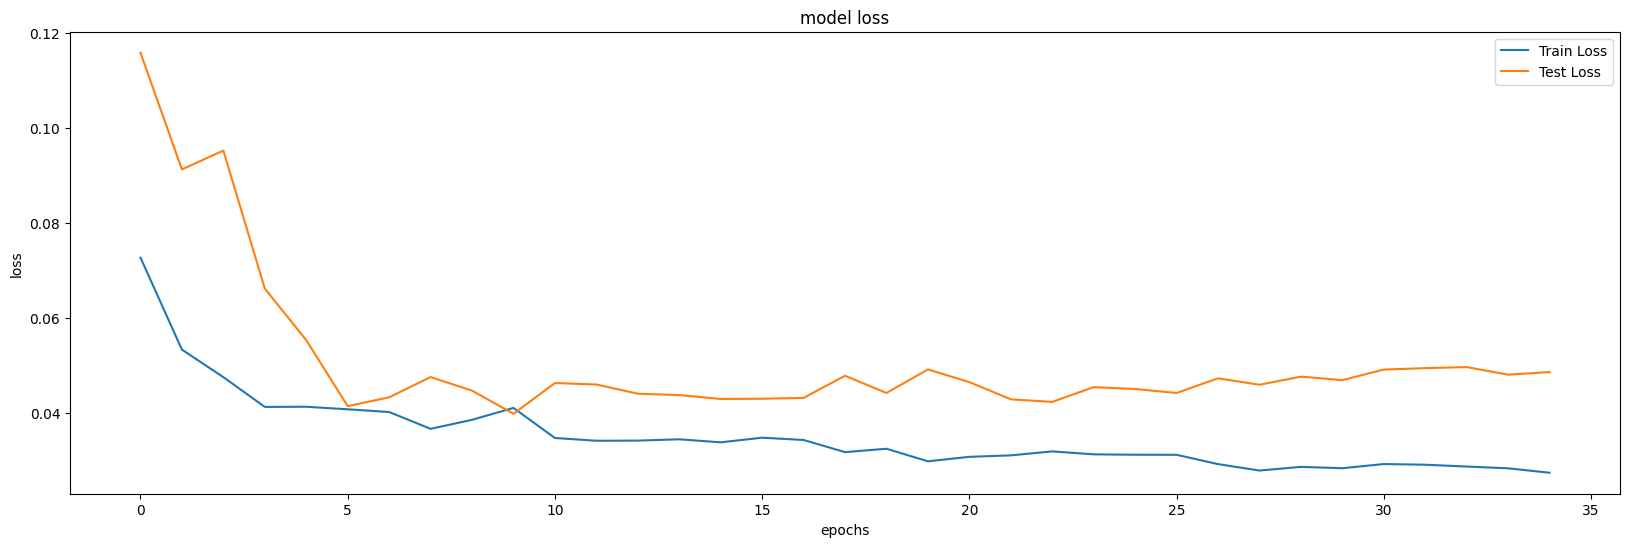

In [16]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [17]:
y_fit = pd.DataFrame(model.predict(X_train), columns=["y_step_1"])
y_pred = pd.DataFrame(model.predict(X_test), columns=["y_step_1"])

y_pred.set_index(y_test.index, inplace=True)
y_fit.set_index(y_train.index, inplace=True)
# y
y_train

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10
0,0.000000,0.256852,0.726162,0.268906,0.347736,0.358994,0.422053,0.419031,0.421182,0.418911
1,0.297135,0.726162,0.268906,0.347736,0.358994,0.422053,0.419031,0.421182,0.418911,0.416545
2,0.741006,0.268906,0.347736,0.358994,0.422053,0.419031,0.421182,0.418911,0.416545,0.425117
3,0.308534,0.347736,0.358994,0.422053,0.419031,0.421182,0.418911,0.416545,0.425117,0.424492
4,0.383092,0.358994,0.422053,0.419031,0.421182,0.418911,0.416545,0.425117,0.424492,0.418477
...,...,...,...,...,...,...,...,...,...,...
772,0.450076,0.434937,0.443616,0.448907,0.471974,0.467193,0.467013,0.465255,0.463348,0.460433
773,0.465566,0.443616,0.448907,0.471974,0.467193,0.467013,0.465255,0.463348,0.460433,0.480371
774,0.473775,0.448907,0.471974,0.467193,0.467013,0.465255,0.463348,0.460433,0.480371,0.480640
775,0.478779,0.471974,0.467193,0.467013,0.465255,0.463348,0.460433,0.480371,0.480640,0.481846


In [18]:

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        # preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

C:\Users\mehrd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mehrd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 0.14
Test RMSE: 0.22


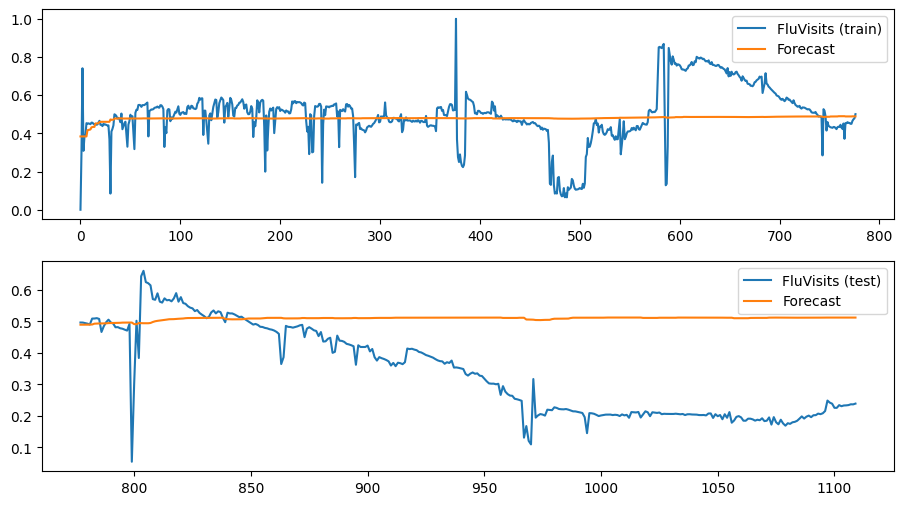

In [19]:


train_rmse = mean_squared_error(y_train["y_step_1"], y_fit, squared=False)
test_rmse = mean_squared_error(y_test["y_step_1"], y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = y_train["y_step_1"].plot(ax=ax1)
ax1 = y_fit["y_step_1"].plot(ax=ax1)
# ax1 = plot_multistep(y_train, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = y_test["y_step_1"].plot(ax=ax2)
ax2 = y_pred["y_step_1"].plot(ax=ax2)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

In [ ]:
# hp ======> hyper parameters = [number_nuron_layer1, number_nuron_layer2, number_nuron_layer3,
#                          number_nuron_layer4, Activation_fuctin_layer1, Activaiton_function_layer2,
#                     Activation_fuctin_layer3, Activation_fuctin_layer4, If for layer1 have Drop_out=1 else 0,
#         If for layer2 have Drop_out=1 else 0, If for layer3 have Drop_out=1 else 0, If for layer4 have Drop_out=1 else 0,
#     If for layer1 have batch_norm=1 else 0, If for layer2 have batch_norm=1 else 0, If for layer1 have batch_norm=3 else 0,
#                       If for layer1 have batch_norm=1 else 0, learning_rate, batch_size]


# in this function we create a function that can build model that can chane evry time

def dynamic_model(hp, train=train):


    activation_function = ["relu","sigmoid","softmax","softsign",
                           "tanh","selu","elu" ,"exponential",
                           "leaky_relu","relu6","silu","gelu",
                           "hard_sigmoid","linear","mish","log_softmax"]
    

    input_layer = keras.layers.Input(shape=(8,))
    layer1 = keras.layers.Dense(hp[0], activation_function[int(hp[4])], name="layer1")(input_layer)
    
#     in this sectino we have 4 layer  so that we have 4 section for dscetion that we have in each layer DropOut or BatchNorm
#   this is layer1 we have 4 condition:
    if ((hp[8] == 1) & (hp[12] == 1)):
        drop1 = keras.layers.Dropout(0.3)(layer1)
        norm1 = keras.layers.BatchNormalization()(drop1)
        layer2 = keras.layers.Dense(hp[1], activation_function[int(hp[5])], name="layer2")(norm1)
    elif ((hp[8] == 1) & (hp[12] == 0)):
        drop1 = keras.layers.Dropout(0.3)(layer1)
        layer2 = keras.layers.Dense(hp[1], activation_function[int(hp[5])], name="layer2")(drop1)
    elif ((hp[8] == 0) & (hp[12] == 1)):
        norm1 = keras.layers.BatchNormalization()(layer1)
        layer2 = keras.layers.Dense(hp[1], activation_function[int(hp[5])], name="layer2")(norm1)
    else:
        layer2 = keras.layers.Dense(hp[1], activation_function[int(hp[5])], name="layer2")(layer1)
        
#    layer2:     
    if ((hp[9] == 1) & (hp[13] == 1)):
        drop2 = keras.layers.Dropout(0.3)(layer2)
        norm2 = keras.layers.BatchNormalization()(drop2)
        layer3 = keras.layers.Dense(hp[2], activation_function[int(hp[6])], name="layer3")(norm2)
    elif ((hp[9] == 1) & (hp[13] == 0)):
        drop2 = keras.layers.Dropout(0.3)(layer2)
        layer3 = keras.layers.Dense(hp[2], activation_function[int(hp[6])], name="layer3")(drop2)
    elif ((hp[9] == 0) & (hp[13] == 1)):
        norm2 = keras.layers.BatchNormalization()(layer2)
        layer3 = keras.layers.Dense(hp[2], activation_function[int(hp[6])], name="layer3")(norm2)
    else:
        layer3 = keras.layers.Dense(hp[2], activation_function[int(hp[6])], name="layer3")(layer2)
        
#     layer3 :         
    if ((hp[10] == 1) & (hp[14] == 1)):
        drop3 = keras.layers.Dropout(0.3)(layer3)
        norm3 = keras.layers.BatchNormalization()(drop3)
        layer4 = keras.layers.Dense(hp[3], activation_function[int(hp[7])], name="layer4")(norm3)
    elif ((hp[10] == 1) & (hp[14] == 0)):
        drop3 = keras.layers.Dropout(0.3)(layer3)
        layer4 = keras.layers.Dense(hp[3], activation_function[int(hp[7])], name="layer4")(drop3)
    elif ((hp[10] == 0) & (hp[14] == 1)):
        norm3 = keras.layers.BatchNormalization()(layer3)
        layer4 = keras.layers.Dense(hp[3], activation_function[int(hp[7])], name="layer4")(norm3)
    else:
        layer4 = keras.layers.Dense(hp[3], activation_function[int(hp[7])], name="layer4")(layer3)
        
#    layer4:        
    if ((hp[11] == 1) & (hp[15] == 1)):
        drop4 = keras.layers.Dropout(0.3)(layer4)
        norm4 = keras.layers.BatchNormalization()(drop4)
        output_layer = keras.layers.Dense(1, "linear", name="output_layer")(norm4)
    elif ((hp[11] == 1) & (hp[15] == 0)):
        drop4 = keras.layers.Dropout(0.3)(layer4)
        output_layer = keras.layers.Dense(1, "linear", name="output_layer")(drop4)
    elif ((hp[11] == 0) & (hp[15] == 1)):
        norm4 = keras.layers.BatchNormalization()(layer4)
        output_layer = keras.layers.Dense(1, "linear", name="output_layer")(norm4)
    else:
        output_layer = keras.layers.Dense(1, "linear", name="output_layer")(layer4)

#     at last we create final model        
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    
#     in this section we complie the model    
    optimizer =keras.optimizers.Adam(learning_rate=hp[16])
    model.compile(loss="mae", optimizer=optimizer, metrics=["mse"])

    # wright the callbacks that we need
#     checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.h5", save_weights_only=True,best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
    
    # fit the model
    history = model.fit(X_train,
                         y_train, 
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping_cb],
                        batch_size=int(hp[17]),
                        epochs=1000,
                        verbose=0)
    
#     in this section we complie the model
    val_pred = model.predict(X_val)
#   because we r2_score dont work with nan values we chane nan value with -999
    val_pred[np.isnan(val_pred)] = -999
        
    solution_fitness = r2_score(y_val, val_pred)
    print(solution_fitness)
 
    return solution_fitness